# **Red convolucional para clasificar imágenes de medicamentos**
**Curso de Introducción a Machine Learning** </a> <br>
**Autores:** Abraham Tamargo,
Ángela Troncoso, 
Tamara Alonso
    &nbsp;&nbsp;&nbsp; **Última modificación:** 23/11/2021

--------------------------------------------------------------------------
## Índice
1. <a href="#c1"> Instalación desde Github </a> <br>
2. <a href="#c2"> Iniciando la webcam   </a> <br>
3. <a href="#c3"> De imágenes a etiquetas   </a> <br>
4. <a href="#c5"> GPT3   </a> <br>
5. <a href="#c4"> Capturando a tiempo real   </a> <br>
6. <a href="#c6"> Conclusiones   </a> <br>


Se aplica la técnica OCR para obtener leer el nombre de los medicamentos a partir de una imagen tomada con la webcam a tiempo real.  
OCR es una tecnología para la detección de texto a partir de imágenes.

Nos basamos en el proyecto que se aloja en https://github.com/mindee/doctr



## 1. Instalación de librerías <a name="c1"> </a>

Se instalan las librerías y dependencias necesarias para la ejecución del notebook. 
Se instala la última versión estable del modelo que vamos a utilizar desde Github (noviembre 2021).

Ojo con el entorno de ejecución, hay que reiniciarlo. Es posible que salga un mensaje de error pero no importa. 

In [18]:
# TensorFlow
#!pip install python-doctr[tf]
# PyTorch
!pip install python-doctr[torch]

# Instalar la versión más actualizada del modelo desde  GitHub
# TensorFlow
#!pip install -e git+https://github.com/mindee/doctr.git#egg=python-doctr[tf]
# PyTorch
!pip install -e git+https://github.com/mindee/doctr.git#egg=python-doctr[torch]

# Instalación de  fuentes gratuitas para la representación de resultados
!sudo apt-get install fonts-freefont-ttf -y

Obtaining python-doctr[torch] from git+https://github.com/mindee/doctr.git#egg=python-doctr[torch]
  Updating ./src/python-doctr clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 95a81a1748740406cd006258b9a68c904e7d4386
  Attempting uninstall: python-doctr
    Found existing installation: python-doctr 0.5.0a0
    Can't uninstall 'python-doctr'. No files were found to uninstall.
  Running setup.py develop for python-doctr
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-freefont-ttf is already the newest version (20120503-7).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Importamos modelo preentrenado. 
En este momento, es necesario reiniciar el entorno de ejecución para que se actualice la última versión instalada.
Para ello, ejecute la celda siguiente o pulse en 'Entorno de ejecución' > 'Reiniciar entorno de ejecución'. 



In [ ]:
#Reiniciar el entorno de ejecución 
import os
os.kill(os.getpid(), 9)

In [2]:
%matplotlib inline
import os

# Escojamos el "backend" deseado
# os.environ['USE_TF'] = '1'
os.environ['USE_TORCH'] = '1'

import matplotlib
import matplotlib.pyplot as plt
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [3]:
#Descargamos e importamos las librerías necesarias
!pip install gTTS
from gtts import gTTS 
from IPython.display import Audio 

import os
!pip install openai
import openai

import numpy as np

In [4]:
# Crear una instancia de un modelo previamente entrenado
predictor = ocr_predictor(pretrained=True)

In [ ]:
# Visualización de la arquitectura del modelo que es una "Convolutional Recurrent Neural Network (CRNN)""
print(predictor)

OCRPredictor(
  (det_predictor): DetectionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(1024, 1024), interpolation='bilinear')
      (normalize): Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))
    )
    (model): DBNet(
      (feat_extractor): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): Ba


## 2. Capturando desde webcam <a name="c92"> </a>

Nuestro modelo funciona a tiempo real, con el video que captura desde la webcam. A continuación se cargan las librerías necesarias para conectar con la webcam en tiempo real. 

In [5]:
# importar las dependencias para conectar con la webcam
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Función para convertir el objeto JavaScript en una imagen OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decodificación de la imagen base (base64 image)
  image_bytes = b64decode(js_reply.split(',')[1])
  # convertir bytes a numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decodificar numpy array a OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Función para convertir la imagen del cuadro delimitador OpenCV Rectangle en una cadena de bytes base64 para superponerla en la transmisión de video
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convertir el array en una imagen tipo PIL 
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # formatear bbox en png para devolver
  bbox_PIL.save(iobuf, format='png')
  # formato de string de retorno
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
# JavaScript para crear correctamente su transmisión de video en vivo usando su cámara web como entrada
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## 3. De imágenes a etiquetas <a name="c3"> </a>

Esta función implementa distancia de Levenshtein (para comparar los nombres de lo medicamentos con los detectados por el sistema).

In [8]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
  #la funcion tiene como entrada dos cadenas de string, s y t, para calcular la distancia Levenshtein entre ellas.
    """ levenshtein_ratio_and_distance:
        Calcula la distancia Levenshtein entre dos cadenas de string.
        
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Inicializar matriz de ceros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Poblar la matriz de cerros con las incidencias de cada caracter en cada string 
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iteramos sobre la matriz para computar el coste de delecciones, insercciones y/o sustituciones de caracteres 
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # Si los caracteres son el mismo en los dos strings en la misma posición [i,j] el coste es 0
            else:
                # Para calcular el resultado con herramientas del paquete Python Lvenshtein, si elegimos calcular el ratio el coste de sustitucion es 2. 
                # si calculamos la distancia, el coste de sustitución es 1 
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Coste de deleccion 
                                 distance[row][col-1] + 1,          # Coste de inserccion 
                                 distance[row-1][col-1] + cost)     # Coste de sustitucion 
    if ratio_calc == True:
        # Computacion de la Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Descomentar si se quiere ver la matriz con todos los numeros calculados
        return "The strings are {} edits away".format(distance[row][col])

Estas funciones permiten comprobar la relación entre las etiquetas con otras cadenas de caracteres. 

In [9]:
#Funcion para sabr si una cadena str está contenida en otra
def palabra_contenida(labels, lista_json):
  r='Null'
  for label in labels:
    for string in lista_json:
      if label in string:
        r= label
        break
  return r

#Función para comparar la lista de labels y las palabras leídas por el modelo y calcular su distancia
def check_matches(labels, lista_json):
  match='Null'
  for string in lista_json:
    for label in labels:
      if label and string:
        matches = levenshtein_ratio_and_distance(label, string, ratio_calc = True), label, string
        if matches[0] > 0.75:
          match=label
          break
  return match

## 4. GPT3: una respuesta más elaborada <a name="c5"> </a>

Usando GPT3 de OpenAI hacemos que la respuesta dada por nuestro modelo sea más rica. Se puede acceder a la API en el siguiente enlace: https://beta.openai.com/playground. 

Para conectar con nuestro modelo, tenemos que usar la apikey personal de cada usuario, que es leída desde un archivo txt alojado en Drive.

In [10]:
#Importar archivos desde Drive
from google.colab import drive
from google.colab import files

drive.mount('/content/drive', force_remount=True)
path = "/content/drive/MyDrive/Proyecto/key.txt"

Mounted at /content/drive


In [11]:
#seleccionar la informacion extra
def coge_extra_info (lista_json, etiqueta):
  extra=[]
  for elemento in lista_json:
    m= levenshtein_ratio_and_distance(etiqueta, elemento, ratio_calc = True), etiqueta, elemento
    if(m[0]<0.50):
      extra.append(elemento)
  if(len(extra)> 10):
    extra= extra[10:20]
  return extra

#leer la clave del fichero
def lee_clave(path):
  file = open(path, "r")
  key = file.read()
  return key

#limpiar la respuesta generada
def limpia_str(string):
  string= string[9:]
  characters = "\\n\\n"
  for x in range(len(characters)):
    string = string.replace(characters[x],"") 
  return string

#reproducir audio
def reproduce_audio(a):
  return IPython.display.Audio(a)

#conectar con gpt3
def gpt3(texto, path):
  openai.api_key = lee_clave(path)
  
  response = openai.Completion.create(
      engine="davinci",
      #prompt="Input: {label ='Ibuprofeno', extra_info = ['1gr', 'via oral']}\nOutput: {\\\"El medicamento es Ibuprofeno, pastillas de 750gramos para via oral}\n\nInput: {label = 'Paracetamol', extra_info = ['650mg', '40 comprimidos EFG', 'MundoGen', 'via oral']}\nOutput: {\\\"El medicamento es Paracetamol, de MundoGen con 40 comprimidos EFG de 650mg para via oral},\n\nInput: {label = ' Aspirina ' , extra_info = [ '500mg',' 20 comprimidos', 'Bayer '], }\nOutput: {\\\" Usted tiene un caja de 20 comprimidos de 500mg de Aspirina \" },\n\nInput: {label = ' Diazepam ' , extra_info = [ ' Normon', '5mg', 'comprimidos']}\nOutput: {\\\"El medicamento que tiene es Diazepam 5 mg \" },\n\nInput: {label = 'Diclofenaco' , extra_info = [ 'Cinfa', '50 mg', 'comprimidos gastroresistentes'  ]\nOutput: {\\\" La caja que tiene es de Diclofenaco 50 mg \" },\n\nInput: {label = 'Lovastatina' , extra_info = [ 'Sandoz', ' 40 mg' ,  'comprimidos EFG ' ]\nOutput: {\\\"El medicamento es Lovastatina, comprimidos EFG de 40 mg \" }\n\nInput: {label = ' Naproxeno' , extra_info = [ 'sódico', 'cinfa' , '550mg' , 'película EFG' ]\nOutput: {\\\" Tiene usted una caja de Naproxeno sódico, con compridos de 550 mg con película EFG\" },\n\nInput: {label = ' Omeprazol' , extra_info = [ 'cinfa', '40 mg', 'cápsulas duras gastroresistentess' ]}\nOutput: {\\\" Tiene una caja de Omeprazol cinfa de 40 mg\" },\n\nInput: {label = 'Vitaminas' , extra_info = [ '' ]}\nOutput: {\\\"Usted tiene una caja de vitaminas \" },\n\nInput: {label = 'Furosemida' , extra_info = [ 'Kern Pharma', ' 40 mg ', 'comprimidos EFG ' ]}\nOutput: {\\\"Bonita caja de Furosemida tiene usted con 40 mg \" }, \n\nInput: {label = 'Ibuprofeno' , extra_info = [ 'Kern Pharma', ' 600 mg ', 'comprimidos EFG ' ]}\nOutput: {\\\"Tiene usted una caja de Ibuprofeno 600 mg }\n\n",
      prompt=texto,
      temperature=0.7,
      max_tokens=64,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
      stop=["Input"] #para que genere un solo output
)
  Respuesta = response.choices[0].text.split(".")
  print(Respuesta)
  return response.choices[0].text

def genera_respuesta(promt, etiqueta, json, path):

  extra_info = coge_extra_info(json, etiqueta)

  #generamos la query concatenando el ultimo input al final
  query= str(prompt)+ "Input: {label="+str(etiqueta)+" , extra_info = "+str(extra_info)
  #con esta query, gpt3 nos da una respuesta
  response=gpt3(query, path)

  #limpiamos la respuesta antes de generar el audio
  response=limpia_str(response)

  #Hacemos que se genere un audio con esta respuesta
  tts = gTTS(text=(str(response)), lang='es')
  tts.save("record.mp3")
  return ("record.mp3")

## 5. Detección de medicamentos en tiempo real <a name="c4"> </a>

Al ejecutar este código, se inicia la webcam (es posible que aparezca una ventana emergente para autorizar a google a usarla).

El usuario debe acercar la caja del medicamento a la cámara, evitando movimientos bruscos e intentando que esté centrada, cerca y sin mucha inclinación.
Cuando el modelo detecte que la caja se corresponde con un medicamento, parará automaticamente.
Entonces generará la respuesta, tanto en formato escrito como en formato de audio. 

<IPython.core.display.Javascript object>

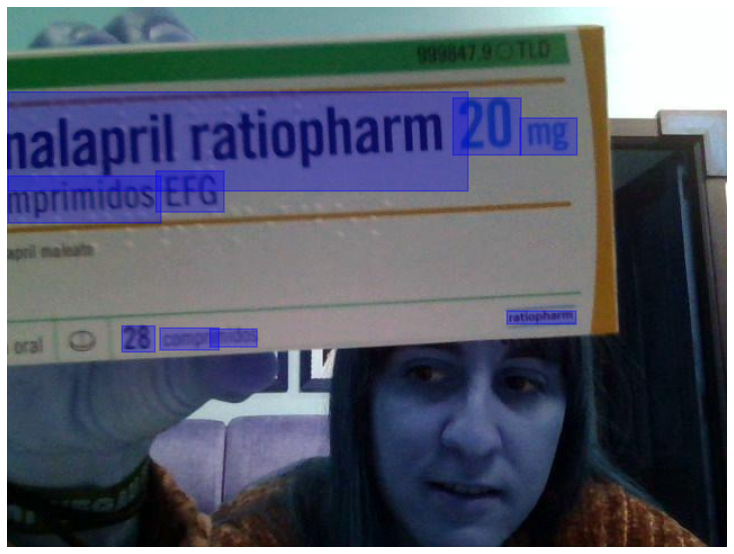

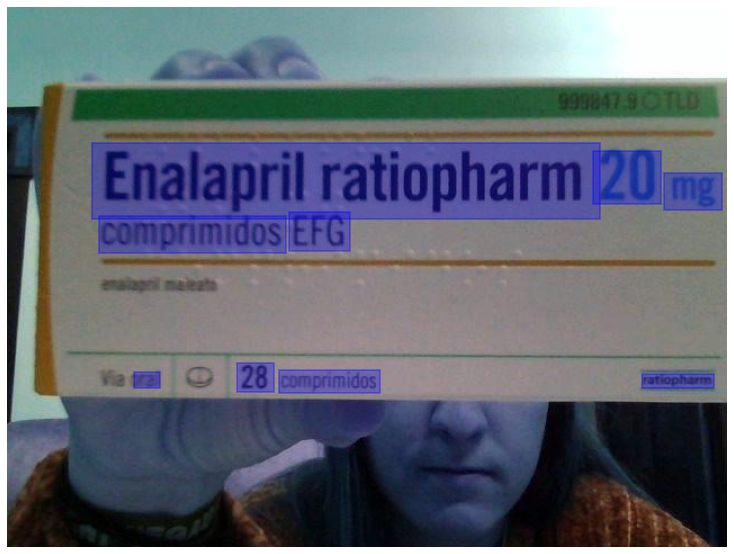

El medicamento es: Enalapril
['}\\nOutput: {\\\\"Tiene usted una caja de Enalapril, comprimidos EFG, a 28 comprimidos, aunque aun no se a aprobado para la venta " },\\n\\n']


In [16]:
#Código para ir tomando fotos desde la Webcam: el código compara con la lista de medicamentos 
#y te devuelve el medicamento exacto que es o el/los medicamento/s más cercano que ha encontrado 
#de acuerdo con la distancia de Levenson
import IPython

lista_json = []
labels = ["Acetaminofen", "Aspirina", "Calcio", "Clortalidona","Diazepam", "Diclofenaco", "Dipirona",
          "Dolalgial","Enalapril","Espirolactona", "Furosemida","Hidroclotiazida","Ibuprofeno","Indometacina",
          "Levotiroxina","Losartan","Lovastatina", "Mask","MASK","Mascarilla","Metoprolol","Naproxeno", "Nifedipina", 
          "Omeprazol", "Paracetamol","Phenergan","Simvastatina", "Vaselina","Vitaminas"]

#Generar GPT3
prompt="Input: {label ='Ibuprofeno', extra_info = ['1gr', 'via oral','dffieef', '-', '92434012.1', 'pastilla']}\nOutput: {\\\"El medicamento es Ibuprofeno, pastillas de 750gramos para que te las tragues enteras\"},\n\nInput: {label = 'Paracetamol', extra_info = ['650mg', '40 comprimidos EFG', 'MundoGen', 'via oral', 'comrimidos', '694021.2', '-', '.', 'partamol']}\nOutput: {\\\"El medicamento es Paracetamol, de MundoGen con 40 comprimidos EFG de 650mg para via oral, esto es mano de santo\"},\n\nInput: {label = ' Aspirina ' , extra_info = [  '500mg',' 20 comprimidos', 'Bayer ', '7024230.4-EFP, ''EFP', 'aa', 'sjdhaf', ]}\nOutput: {\\\" Usted tiene un caja de 20 comprimidos de 500mg de Aspirina , para quitarse sus problemas\" },\n\nInput: {label = ' Diazepam ' , extra_info = [  ' Normon', '5mg', 'comprimidos', 'comidos','m', 'g', 'vía oral','787291.7']}\nOutput: {\\\"El medicamento que tiene es Diazepam 5 mg. Tenga cuidado de no coger drogodepencia\" },\n\nInput: {label = 'Diclofenaco' , extra_info = [  'Cinfa',  '50 mg',  'comprimidos gastroresistentes', 'iw',  '..-', 'aawae']}\nOutput: {\\\"  La caja  que tiene es de  Diclofenaco 50 mg\" },\n\nInput: {label = 'Lovastatina' , extra_info = [  'Sandoz',  ' 40 mg' ,   'comprimidos EFG ',  'vía',  'ooral']}\nOutput: {\\\"El medicamento es Lovastatina, comprimidos EFG de 40 mg\" },\n\nInput: {label = ' Naproxeno' , extra_info = [  'sódico',  'cinfa' ,  '550mg' ,  'película EFG',  '29431¡134',  'naproxen']}\nOutput: {\\\" Tiene usted una caja  de Naproxeno sódico, con compridos de 550 mg con película EFG, bebalo con agua porque esta duro\" },\n\nInput: {label = ' Omeprazol' , extra_info = [  'cinfa',  '40 mg',  'cápsulas duras gastroresistentess' ]}\nOutput: {\\\" Tiene una caja de Omeprazol cinfa de 40 mg\" },\n\nInput: {label = 'Vitaminas' , extra_info = [  'A' ,   'B',  'C',  'D',  'E',  'K' ,  'complemento',  'alimenticio']}\nOutput: {\\\"Usted tiene una caja de vitaminas pero siga una dieta equilibrada \" },\n\nInput: {label = 'Furosemida' , extra_info = [  'Kern Pharma',  ' 40 mg ', 'comprimidos EFG ']}\nOutput: {\\\"Bonita caja de Furosemida tiene usted con 40 mg \" }, \n\n",

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
temporizador= 0

while True:
    js_reply = video_frame(label_html, bbox) 
    etiqueta=''

    #si detecta a la primera  
    if not js_reply or set(lista_json).intersection(set(labels)):
        etiqueta= str(set(lista_json).intersection(set(labels)))
        print("El medicamento es: "+etiqueta)
        audio = genera_respuesta(prompt, etiqueta, lista_json, path)
        eval_js('shutdown=true')
        video_frame(label_html, bbox)
        break

    #si no
    else:
      etiqueta=palabra_contenida(labels, lista_json)
      if(etiqueta=='Null'):
        etiqueta=check_matches(labels, lista_json)
        temporizador= temporizador+1

      if(etiqueta!='Null'):
        print("El medicamento es: "+ str(etiqueta))
        audio = genera_respuesta(prompt, etiqueta, lista_json, path)
        eval_js('shutdown=true')
        video_frame(label_html, bbox)
        break
      
      if(temporizador>2):
        texto= "No se detecta la caja, inténtelo de nuevo. Recuerde evitar el movimiento y colocarla cerca de la cámara."
        print(texto)
        tts = gTTS(text=(texto), lang='es')
        tts.save("record2.mp3")
        audio ="record2.mp3"
        eval_js('shutdown=true')
        video_frame(label_html, bbox)
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    
    matplotlib.image.imsave('frame_temp.jpg', frame)
    #
    document = DocumentFile.from_images("frame_temp.jpg")
    result = predictor(document)
    result.show(document)

    # JSON export
    json_export = result.export()
    #print(json_export)

    for i in range(len(json_export ["pages"][0]["blocks"])):
      for j in range(len(json_export ["pages"][0]["blocks"][i]["lines"][0]["words"])):
        lista_json.append(json_export ["pages"][0]["blocks"][i]["lines"][0]["words"][j]["value"])

#Para mostrar el resultado en un audio
#se usa un generador de voz natural
reproduce_audio(audio)

## 6. Conclusiones <a name="c6"> </a>

Durante el transcurso del proyecto, nos dimos cuenta de que el proceso de reconocimiento de cajas de medicamento no obtiene buenos resultados a no ser que el modelo "lea" el nombre del medicamento en la caja, que es lo que nuestro público objetivo no puede hacer con suficiente claridad.
Así, la aplicación de técnicas OCR son la solución perfecta para el problema que nos ocupa.

Después, no tiene sentido en este problema que la respuesta del modelo sea texto, pues alguien con dificultad de visión tampoco podrá leerlo. Por ello el siguiente paso es la generación de un audio con el resultado obtenido.
Para obtener una respuesta más amigable y que además incorpore otros datos, no solo el nombre del medicamento, aplicamos GPT3.

Partimos de una idea interesante y exploramos distintas soluciones para llegar a ella, desde lo más general (redes neuronales pre entrenadas) a modelos relacionados con el reconocimiento de textos en imágenes. Finalmente se ha obtenido un resultado que se acerca bastante a lo que habíamos pensado. Estamos contentos con el trabajo realizado y con la solución obtenida. 

